### Conditional Heteroskedasticity

금융시장의 이분산성에 대해 이해하고 고급 시계열 변동성 분석 방법에 대해 배우도록 한다

#### 1. Stationaity and Heteroskedasticity

**1.1 Stationarity**

AR process의 기본 가정은 다음과 같다

- strict stationarity
    - 임의의 자연수 $t_1, t_2, \cdots, t_n$과 자연수 k에 대하여 n개의 확률변수에 대한 결합확률밀도함수와, 이 n개의 확률변수에서 k만큼의 시간 축을 이동하였을 때의 결합확률밀도함수가 동일하다면, 이 시계열은 강정상성(Strict Stationarity)를 갖는다
    - 따라서 어떤 확률과정이 강정상성 조건을 만족한다면 모든 n에 대하여 결합확률밀도함수가 시간대를 바꾸어도 동일하다는 것을 보여야 하므로, 어떠한 시간대이든 분포가 항상 동일해야 한다

- weak stationarity
    - 확률과정이 유한한 2차 적률(**Finite Second Moment**)을 갖고, 기댓값과 분산이 시점 t와 무관하게 항상 일정하며 자기공분산이 시점 t가 아닌 시차 k에 의존한다면 이를 약한 의미의 정상성을 갖는다
    - $\mathrm{E}(Z_t) = \mu,~~ \mu \in \mathbf{R}$
    - $\mathrm{Var}(Z_t) = \sigma ^ 2, ~~ \sigma ^ 2 \in \mathbf{R}$
    - $\mathrm{Cov}(Z_t, Z_{t+k}) = \sigma_K, ~~\mathrm{for~any~t,h \geq 1}$

즉 금융 데이터(여기서 보통 1차 차분한 데이터를 의미한다)가 weak stationary 하다면, 그 데이터를 제곱한 수와 절대값을 취한 수 또한 weak stationary의 가정을 만족해야 한다. 그러나, 실제로 데이터에 변형을 취하면 자산가격은 weak stationarity를 보이지 않는다

In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

kosdaq = pdr.DataReader("KOSDAQ", "naver", start_date, end_date).astype(float)
kosdaq

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,672.53,674.30,666.62,674.02,783730.0
2020-01-03,677.57,679.37,668.10,669.93,903858.0
2020-01-06,660.08,663.10,653.61,655.31,884278.0
2020-01-07,660.87,664.21,659.18,663.44,970306.0
2020-01-08,657.24,658.14,637.43,640.94,1379708.0
...,...,...,...,...,...
2022-12-23,704.93,704.93,691.25,691.25,1107302.0
2022-12-26,691.94,696.96,686.80,694.68,797707.0
2022-12-27,697.25,704.21,697.25,704.19,901437.0


In [2]:
ret = np.log(kosdaq.Close / kosdaq.Close.shift(1)).dropna()
ret

Date
2020-01-03   -0.006087
2020-01-06   -0.022065
2020-01-07    0.012330
2020-01-08   -0.034503
2020-01-09    0.038489
                ...   
2022-12-23   -0.033809
2022-12-26    0.004950
2022-12-27    0.013597
2022-12-28   -0.016928
2022-12-29   -0.019072
Name: Close, Length: 741, dtype: float64

weak stationary 가정을 만족하는지 보여주기 위해서 다음과 같은 자산 가격 시계열을 새롭게 생성한다

In [3]:
ret_square = ret ** 2
ret_abs = np.abs(ret)

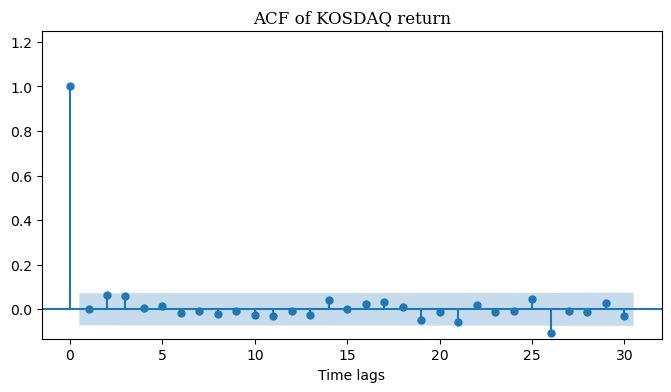

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ return', fontsize = 12, fontfamily = 'Serif')
plt.show()

1차 차분한 수익률 벡터에 대해서는 위와 같이 안정성을 띄는 것을 볼 수 있다

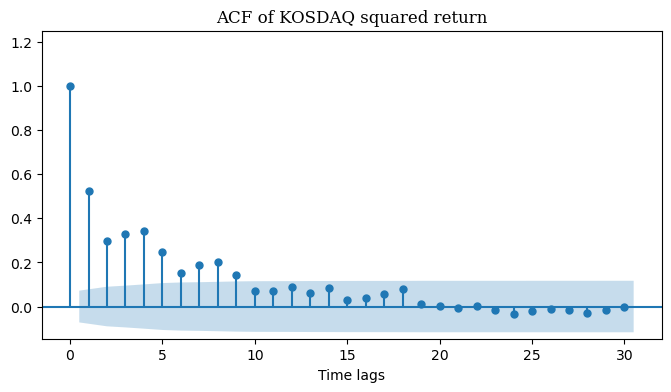

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret_square, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ squared return', fontsize = 12, fontfamily = 'Serif')
plt.show()

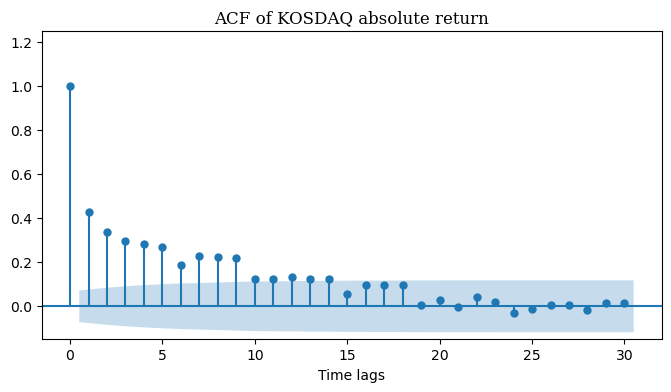

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret_abs, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ absolute return', fontsize = 12, fontfamily = 'Serif')
plt.show()

그러나, 각각 수익률의 제곱과 절대값은 안정적이지 않다. 따라서, 대부분의 금융 시계열 데이터는 IID 가정을 만족시키지 못한다는 것을 알 수 있다.

이것이 우리가 금융 시계열 데이터에서 이분산성을 고려해야 하는 이유이다

**1.2 Characteristics of Volatility**

주식 변동성의 특별한 특징은 직접 관측할 수 없다는 것이다. 그러나 변동성은 직접적으로 관찰할 수는 없지만 자산 수익률에서 흔히 볼 수 있는 몇 가지 특징을 가지고 있다.

1. 변동성 군집이 존재한다. 즉, 특정 기간에는 변동성이 높고 다른 기간에는 낮을 수 있다
2. 변동성은 시간이 지남에 따라 지속적인 방식으로 진화한다. 즉, 변동성의 널뛰기 현상은 드물다
3. 변동성이 무한대로 발산되지 않는다. 즉, 변동성은 일정한 범위 내에서 변동성이 변한다는 것이다. 통계적으로 말하면 변동성은 종종 정지해 있다는 것을 의미한다
4. 넷째, 변동성은 레버리지 효과로 일컬어지는 큰 가격 상승이나 큰 가격 하락에 다르게 반응하는 것으로 보인다. 이러한 속성들은 변동성 모형의 발전에 중요한 역할을 한다

일부 변동성 모형은 앞서 언급한 특징을 포착하지 못해 기존 모형의 약점을 보완하기 위해 구체적으로 제안되었다. 예를 들어, EGARCH 모형은 큰 긍정적인 자산 수익률과 부정적인 자산 수익률이 유발하는 변동성의 비대칭성을 포착하기 위해 개발되었다

Text(0.5, 1.0, 'Characteristis of volatility')

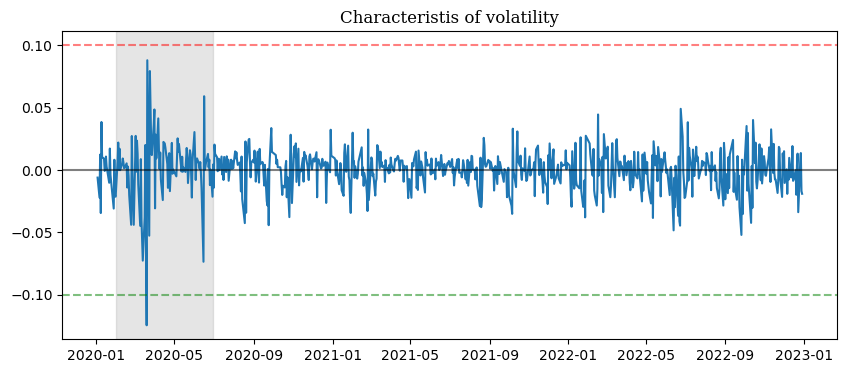

In [7]:
plt.figure(figsize = (10,4))
plt.plot(ret)
plt.axvspan('2020-02-01', '2020-06-30', color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(0.1, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-0.1, color = 'green', linestyle = '--', alpha = 0.5)
plt.title('Characteristis of volatility', fontfamily = 'Serif')

위 그래프와 같이 변동성이 심한 구간에서는 한동안 변동이 심해지는 **변동성 군집(Volatility clustering)** 현상을 확인할 수 있으며, 발산하지 않고 비교적 안정적인 범위 내에서 진동하는 모습을 포착할 수 있다.

#### 2. Model Building

변동성 모형을 적절한 관점에서 설명하기 위해서는 $F_{t-1}$이 주어진 $r_t$의 조건부 평균과 분산을 고려하는 것이 유익하다

$$μ_t = E(r_t|F_{t−1}), σ_t^2 = \mathrm{Var}(r_t|F_{t−1})=E[(r_t −μ_t)^2|F_{t−1}]$$

여기서 $F_{t-1}$이란 $t-1$시기에 가용가능한 모든 정보의 집합이다. 여기서 얻을 수 있는 정보에는 정보의 비대칭성이나 비효율적 시장이 아니다.
$\mathrm{ARCH}$ 모형 추정을 위해 $r_t$가 일부 설명 변수가 있는 안정적인 $\mathrm{ARMA}(p,q)$모형과 같은 간단한 시계열 모형을 따른다고 가정한다

$$r_t = μ_t + a_t, ~~~~~ μ_t = \sum_{i=1}^p \phi_i y_{t-i} + a_t - \sum_{i=1}^q \theta_i a_{t-i}, ~~~~~ y_t = r_t - \phi_0 - \sum_{i=1}^k β_i x_{it}$$

여기서 $y_t$는 단순히 설명 변수의 효과를 제거한 후의 조정된 임의의 time series를 나타낸다. 위 두개의 식에 의해

$$\sigma_t^2 = \mathrm{Var}(r_t|F_{t-1}) = \mathrm{Var}(a_t |F_{t-1})$$

임을 보일 수 있다

조건부 이분산 모형은 크게 두 가지로 나눌 수 있는데, $\sigma_t^2$의 변동을 함수로 표현하는 방식과 $\sigma_t^2$의 변동을 확률방정식으로 해석하는 것으로 나뉜다. $\mathrm{ARCH}$모형은 전자에 속하고, $\mathrm{SV model}$은 후자에 속한다

**test ARCH effect**

Volatility model을 제작하기 위해서는 다음과 같은 과정이 필요하다

1. 데이터의 Serieal Dependence를 테스트하고 필요한 경우 Linear dependence를 제거하기 위해 return series에 대한 계량 모형을 구축하여 mean equation을 지정한다
2. mean equation의 잔차를 사용하여 $\mathrm{ARCH}$ 효과를 검정한다
3. $\mathrm{ARCH}$효과가 통계적으로 유의한 경우 volatility model을 지정한다. 그 후 mean, volatility equation 추정을 한다
4. 적합화된 모형을 점검하고 필요한 경우 다시 확인한다

$a_t = r_t - \mu_t$라고 가정하자. $a_t$에 제곱을 취한 $a_t^2$은 $\mathrm{ARCH}$ 효과로 알려진 조건부 이분산을 확인하기 위해 사용된다. $a_t^2$은 다음과 같이 전개가 가능하다

$$a_t^2 = \alpha_0 + \alpha_1a_{t-1}^2 + \cdots + \alpha_m a_{t-m}^2 + e_t, ~~~~~ t=m+1, \cdots, T$$

여기서 $e_t$는 오차 항을 의미하고, $m$은 기간을 의미한다. 조건부 이분산의 효과를 추정하기 위해 귀무가설을 다음과 같이 설정한다

$$H_0 : \alpha_1 = \cdots = \alpha_m = 0$$

위 가설을 해석하면, $a_t^2$에 대한 과거치들의 자기상관계수가 0이라는 뜻이므로 ARCH효과가 없다는 의미이다. $\mathrm{SSR_0} = \sum_{t=m+1}^T (a_t^2 - \bar \omega)^2$이고, $\bar \omega = \frac{1}{T}\sum_{t=1}^T a_t^2$이다. 표본 평균은 $a_t^2$이고 $\mathrm{SSR_1} = \sum_{t=m+1}^T \hat e_t^2$이다. $\hat e_t^2$는 least squares residual 추정으로 구할 수 있다. 그러면 다음과 같은 통계량을 얻는다

$$F = \frac{\mathrm{SSR_0 - SSR_1} / m}{\mathrm{SSR_1} / (T - 2m - 1)}$$

위 통계량은 $\Chi ^2$분포를 따른다

#### 3. ARCH model

$\mathrm{ARCH}$ 모형은 다음과 같이 추정된다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \cdots + \alpha_ma_{t-m}^2$$

여기서 $\{\epsilon_t\}$는 평균이 0이고 분산이 1인 IID random variables sequence이다$(i>0$일 때, $\alpha_0 > 0, \alpha_i \geq 0)$. 위 모형을 해석하면, 현재의 충격은 이전의 충격들의 영향으로 이뤄진 것이다. 즉, 변동성의 군집현상을 어느정도 설명하려고 한 시도로 보인다. $\mathrm{ARCH}$ 모형을 이해하기 위해서는 우선 $\mathrm{ARCH}(1)$ 모형을 알아봐야 한다

$$a_t = \sigma_t \epsilon_t,~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2$$

여기서 $\alpha_0 > 0, \alpha_1 \geq 0$이다. 우선, $a_t$의 unconditional mean을 0으로 만든다

$$E(a_t) = E[E(a_t|F_{t-1})] = E[\sigma_t E(\epsilon_t)] = 0$$

$a_t$의 unconditional variance는 다음과 같이 구할 수 있다

$$\mathrm{Var}(a_t) = E(a_t^2) = E[E(a_t^2|F_{t-1})] = E(\alpha_0 + \alpha_1 a_{t-1}^2) = \alpha_0 + \alpha_1 E(a_{t-1}^2)$$

$a_t$는 stationart process이고 $E(a_t) = 0, \mathrm{Var}(a_t) = \mathrm{Var}(a_{t-1}) = E(a_{t-1}^2)$이므로, $\mathrm{Var}(a_t) = \alpha_0 + \alpha_1\mathrm{Var}(a_t)$이며 $\mathrm{Var}(a_t) = \frac{\alpha_0}{1-\alpha_1}$이다. $a_t$의 분산은 양수여야 하기 떄문에, $0 \leq \alpha_1 < 1$이어야만 한다.

$\mathrm{ARCH}$ 모형의 가장 큰 단점 네 가지는 다음과 같다

1. 음의 방향 충격과 양의 방향의 충격을 잔차를 제곱함으로써 같은 것으로 간주한다. 그러나 실증적으로는 음의방향과 양의 방향의 충격의 크기가 다른 것으로 나타난다
2. $\mathrm{ARCH}$ 모형은 제약이 너무 크다. 한 예로, $\mathrm{ARCH}(1)$ 모형의 $\sigma_1^2$는 닫힌구간 $[0, \frac{1}{3}]$에 있어야 한다. 실증적으로는, 이러한 가정이 지켜지지 않는 경우가 많다
3. $\mathrm{ARCH}$ 모형은 새로운 insight를 얻을 수 없다. 단지 변동의 형태를 기술하는 방법을 제공할 뿐, 무엇이 변동성을 불러 일으키는지는 알 수 없다
4. $\mathrm{ARCH}$ 모형은 종종 변동성을 과도하게 추정할 위험이 존재한다

#### example 1

KOSDAQ 지수 시계열 데이터에 대해서 2020년 1월 1일부터 2022년 12월 31일까지의 변동성을 추정하고 적절한 ARCH 모형을 추정하라

$\mathrm{ARCH}$모형 추정을 위해 `arch` library를 import 하도록 한다

In [8]:
import arch

$\mathrm{ARCH}$모형의 차수를 정하기 위해서 residual인 $a_t^2$에 대해 Partial ACF 검정 값을 참고해야 한다

In [9]:
a = ret - ret.mean()
a

Date
2020-01-03   -0.006097
2020-01-06   -0.022075
2020-01-07    0.012320
2020-01-08   -0.034513
2020-01-09    0.038478
                ...   
2022-12-23   -0.033819
2022-12-26    0.004939
2022-12-27    0.013586
2022-12-28   -0.016938
2022-12-29   -0.019083
Name: Close, Length: 741, dtype: float64

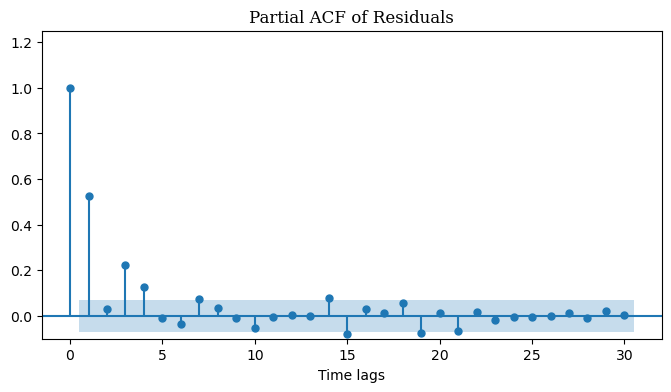

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(a**2, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial ACF of Residuals', fontsize = 12, fontfamily = 'Serif')
plt.show()

기각역을 유의하게 벗어나는 지점은 $m=1$혹은 $m=4$ 지점이다. $a_t^2$에 대해 적절한 차수는 1 혹은 4가 된다

$\mathrm{ARCH}$모형의 인수로는 자산의 수익률 Series를 넣으면 된다. parameter는 다음과 같이 설정한다

- `vol` : 추정 방법을 선택한다. 기본값은 GARCH이므로, ARCH모형 추정을 위해서는 ARCH로 지정해야 한다
- `p` : 변동성에 대한 차수이다. 여기서는 4로 지정을 한다

In [11]:
arch_model = arch.arch_model(ret, vol = 'ARCH', p = 4)
result = arch_model.fit()
print(result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 3613394925.1183085
Iteration:      2,   Func. Count:     23,   Neg. LLF: 89037.4602604182
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1111.2213230762686
Iteration:      4,   Func. Count:     46,   Neg. LLF: 392918562.88039625
Iteration:      5,   Func. Count:     60,   Neg. LLF: 142557.43067192376
Iteration:      6,   Func. Count:     74,   Neg. LLF: 13088.136219237562
Iteration:      7,   Func. Count:     87,   Neg. LLF: 107554.57081992965
Iteration:      8,   Func. Count:     95,   Neg. LLF: -1333.1491701611594
Iteration:      9,   Func. Count:    104,   Neg. LLF: -349.53420407327974
Iteration:     10,   Func. Count:    114,   Neg. LLF: 356507.8927365858
Iteration:     11,   Func. Count:    122,   Neg. LLF: -148.63526934939864
Iteration:     12,   Func. Count:    132,   Neg. LLF: -1977.7872800497062
Iteration:     13,   Func. Count:    140,   Neg. LLF: -2079.250026713419
Iteration:     14,   Func. Count:    148,   Neg. L

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


위 추정 결과를 해석하면 아래와 같다

$$r_t = 0.00127 + a_t$$
$$a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = 0.00009 + 0.1768 a_{t-1}^2 + 0.1746 a_{t-2}^2 + 0.1746 a_{t-3}^2 + 0.1746 a_{t-4}^2$$

#### Exercise 1
위 경우에서 ARCH추정 모형의 변동성에 대한 차수가 1일때를 고려하여 모형을 적합화하라. 어떤 결과가 나오는가? 적합화된 결과의 계수는 적절한가? 차수를 높게 지정하였을 때 우려되는 점은 무엇인가?

#### 4.GARCH Model

$\mathrm{ARCH}$모형은 매우 간단하였지만, 추정해야 할 계수가 늘어난다는 단점 때문에 점차 더욱 간단한 모형에 대한 요구가 늘어나기 시작하였다. Boller slev는 $\mathrm{ARCH}$모형을 일반화한 Generalized ARCH ($\mathrm{GARCH}$)모형을 제안하였는데, 변동성에 대한 ARMA모형을 추정한 것과 유사한 형태이다. 변동성을 두개의 설명변수를 통해 추정하였기에 추정해야 할 parameter가 대폭 감소하는 장점이 있다

$a_t$가 $\mathrm{GARCH}(m,s)$모형을 따를 경우 다음과 같이 나타낼 수 있다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-1}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

$\eta_t = a_t^2 - \sigma_t^2$라고 가정하면 $\mathrm{GARCH}$ 모형은 다음과 같이 표현 가능하다

$$a_t^2 = \alpha_0 + \sum_{i=1}^{\max (m,s)} (\alpha_i + \beta_i) a_{i-1}^2 + \eta_t - \sum_{j=1}^s \beta_j \eta_{t-j}$$

여기서 $\eta_t$는 martingale difference Series, iid sequence로써 다음과 같은 성질을 가진다
$$E(\eta_t) = 0$$
$$\mathrm{Cov}(\eta_t, \eta_{t-j}) = 0 ~~~ \mathrm{for} ~~ j \geq 1$$

$\mathrm{ARMA}$ 모형에서와 같이 $a_t^2$의 기대값을 다음과 같이 추정 가능하다

$$E(a_t^2) = \frac{\alpha_0}{1 - \Sigma_{i=1}^{\max (m,s)}(\alpha_i + \beta_i)}$$

$\mathrm{GARCH}(1,1)$모형의 경우

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2, ~~~~~ 0 \leq \alpha_1, \beta_1 \leq 1, (\alpha_1 + \beta_1) < 1$$

이다. 여기서 제약조건은 변동성이 **발산하지 않는다**로 해석할 수 있다

#### example 2

KOSDAQ 지수에 대해 2020년 1월 1일부터 2022년 12월 31일까지의 $\mathrm{GARCH}$ 모형을 추정하라. 추정된 모형을 가지고 적절한 방법으로 시각화하라

$\mathrm{GARCH}$ 모형의 차수를 정하는 것은 쉽지 않다. 다만, 대부분의 경우 order가 (1,1), (1,2), (2,1)이기 때문에, 세 모형을 모두 추정 후 비교하여 선정하는 방식을 택한다

$\mathrm{GARCH}(1,1)$인 경우

In [12]:
garch_model1 = arch.arch_model(ret, vol = 'GARCH', p = 1, q = 1)
result1 = garch_model1.fit()
print(result1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.860446908195665e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -2073.4749769890805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2073.474979183926
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2073.47
Distribution:                  Normal   AIC:                          -4138.95
Method:            Maximum Likelihood   BIC:                          -4120.52
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:     

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


$\mathrm{GARCH}(1,2)$인 경우

In [13]:
garch_model2 = arch.arch_model(ret, vol = 'GARCH', p = 1, q = 2)
result2 = garch_model2.fit()
print(result2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2104304165.7266545
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2068.5687374886747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2068.568740277803
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2068.57
Distribution:                  Normal   AIC:                          -4127.14
Method:            Maximum Likelihood   BIC:                          -4104.10
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:        

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


$\mathrm{GARCH}(2,1)$인 경우

In [14]:
garch_model3 = arch.arch_model(ret, vol = 'GARCH', p = 2, q = 1)
result3 = garch_model3.fit()
print(result3.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1795287482.7827756
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2065.3305891999944
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2065.330591079876
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2065.33
Distribution:                  Normal   AIC:                          -4120.66
Method:            Maximum Likelihood   BIC:                          -4097.62
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:        

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


종합적으로 고려해 봤을 때, $\mathrm{GARCH}(1,2)$인 경우가 가장 성능이 좋으므로, 최종 모델을 다음과 같이 추정한다

$$r_t = 0.00095 + a_t$$
$$a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = 0.00003 + 0.2 a_{t-1}^2  - 0.35 σ_{t-1}^2 - 0.35 σ_{t-2}^2$$

추정된 변동성은 `conditional_volatility` 속성을 사용하여 plotting 가능하다

Text(0.5, 1.0, 'Conditional Volatility')

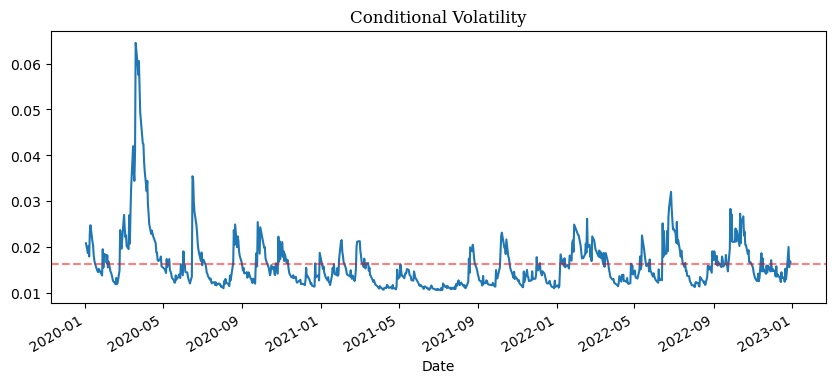

In [15]:
result2.conditional_volatility.plot(figsize = (10, 4))
plt.axhline(result2.conditional_volatility.mean(),
            color = 'red', linestyle = '--', alpha = 0.5)
plt.title('Conditional Volatility', fontfamily = 'Serif', fontsize = 12)

#### Exercise 2.

KOSPI와 KOSDAQ 중 어느 시장이 더 리스크가 큰지 예상하라. 2020년 1월부터 2022년 12월 31일까지의 KOSPI data를 import하라. 적절한 GARCH모형을 추정하고 시각화하라. KOSDAQ과 KOSPI중 변동성(리스크)이 큰 시장은 어디인가? 예상한 결과와 같은가?